##  Hovmöller diagrams of nutrient, temperature, ice and biomass throughout the Nordic Sea 
### This is to understand more of the dynamics of changes between these two regions, to give us a better idea on how to explain these diagrams?
___

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

#### Get MARBL-SPECTRA biomass and year information 
________

In [3]:
phyto_bmss = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/phyto_bmss_62yr.nc')

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/phyto_bmss_62yr.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/phyto_bmss_62yr.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset year
			found dataset nlat
			found dataset nlon
			found dataset TLAT
			found dataset TLONG
			found dataset phytoC_summer_bm
			found dataset phytoC_spring_bm
			found dataset phytoC_fall_bm
			found dataset phytoC_winter_bm
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x10000 ext_ncid 0x10000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/phyto_bmss_62yr.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 7 natts: 0
		 DIMENSION - dimid: 0 name: year len: 62 unlimited: 0
		 DIMENSION - dimid: 1 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 2 name: nlon le

### These are in pop grid, so making a hovmoller will actually not be as easy, let's import regrided-products of NO3 to see how nutrients are looking throughout depth across the Arctic?

In [4]:
### First 20 year climatology GNG595
file = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid'
newNCDFfiles1 = sorted(glob(f'{file}/regrid_SPECTRA_TEMP.*.nc', recursive=True),
                      key=numericalSort)
ds_01= xr.open_mfdataset(newNCDFfiles1[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [5]:
%%time
temp_ds_inter = np.empty([62,12,60,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,:,:,:]

CPU times: user 22.7 s, sys: 1min 17s, total: 1min 39s
Wall time: 8min 22s


## Important high vs low temp, no3 and ice years 

In [6]:
low_no3_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')
high_no3_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_ice_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')
high_ice_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
low_temp_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')
high_temp_years_arctic = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')

In [7]:
years = np.arange(1,62,1)
years

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

### I need to make a hovmoller that crosses in latitude across the Nordic Sea, and one that crosses through the central Arctic... let's see how these would look like

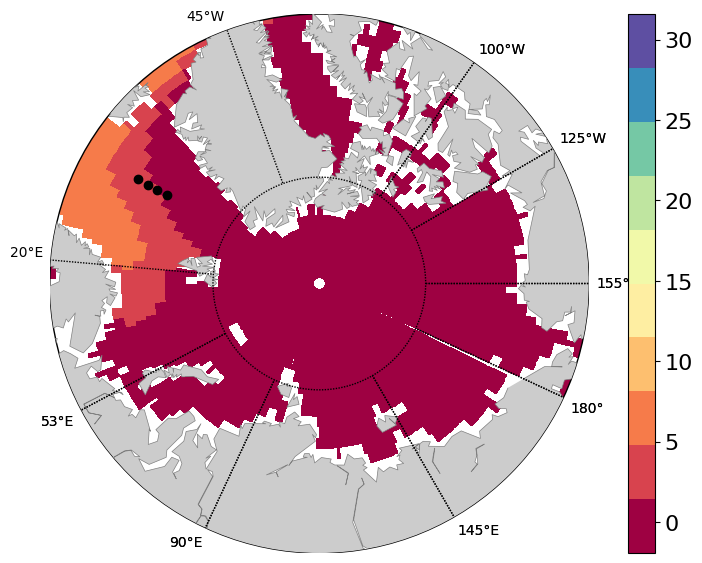

In [8]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True,
            boundinglat=65,
            lon_0=180+(-100+-30)/2.,resolution='c')

x, y = m(*np.meshgrid(ds_01.lon,ds_01.lat))

m.pcolormesh(x,y,temp_ds_inter[0,0,0,:,:],shading='flat',cmap=plt.cm.get_cmap('Spectral', 10))
cbar=plt.colorbar() 
cbar.ax.tick_params(labelsize=16)

x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[160]))
m.plot(x1,y1,'o',color='k')
x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[161]))
m.plot(x1,y1,'o',color='k')
x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[162]))
m.plot(x1,y1,'o',color='k')
x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[163]))
m.plot(x1,y1,'o',color='k')


m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
m.plot
plt.show()

## this is the actual values of the differnt regions that I want 
Arctic Regions

|Region| Latitude | Longitude | Matrix Inputs       |
|------|----------|-----------|---------------------|
|`ao`  |170:180   |:          |`[:,170:180,:]`      |
|`cs`  |149:170   |0:25       |`[:,149:170,0:25]`   |
|`bs`  |149:170   | 25:55     |`[:,149:170,25:55]`  |
|`ca`  |149:170   |55:80     |`[:,149:170,55:110]` |
|`bb`  |149:170   |80:135    |`[:,149:170,110:135]`|
|`ess` |149:170   |325:360    |`[:149:170,325:360]` |
|`ls`  |149:170   |270:325    |`[:,149:170,270:325]`|
|`ks`  |149:170   |233:270    |`[:,149:170,233:270]`|
|`bts` |149:170   |200:233    |`[:,149:170,205:233]`|
|`ns`  |149:170   |155:200    |`[:,149:170,155:205]`|

## Organize the plot
1. x axis = latitude ---> ds_01.lat[149:170]
2. y axis = depth ----> ds_01.z_t[:]
3. temperature should be ---> np.nanmean(ds_01.TEMP[:,:,149:170,175],axis=0)

In [9]:
temp_ds_inter.shape

(62, 12, 60, 180, 360)

In [10]:
x2 = ds_01.lat[149:170] # Latitude 
y2 = ds_01.z_t[0:50]/100 # convert cm to m 
temp2 = np.nanmean(temp_ds_inter[:,:,0:50,149:170,175],axis=(0,1)) # Average through months and 62 years... 
temp_low = np.nanmean(temp_ds_inter[low_temp_years_arctic,:,0:50,149:170,175],axis=(0,1,2))
temp_high = np.nanmean(temp_ds_inter[high_temp_years_arctic,:,0:50,149:170,175],axis=(0,1,2))

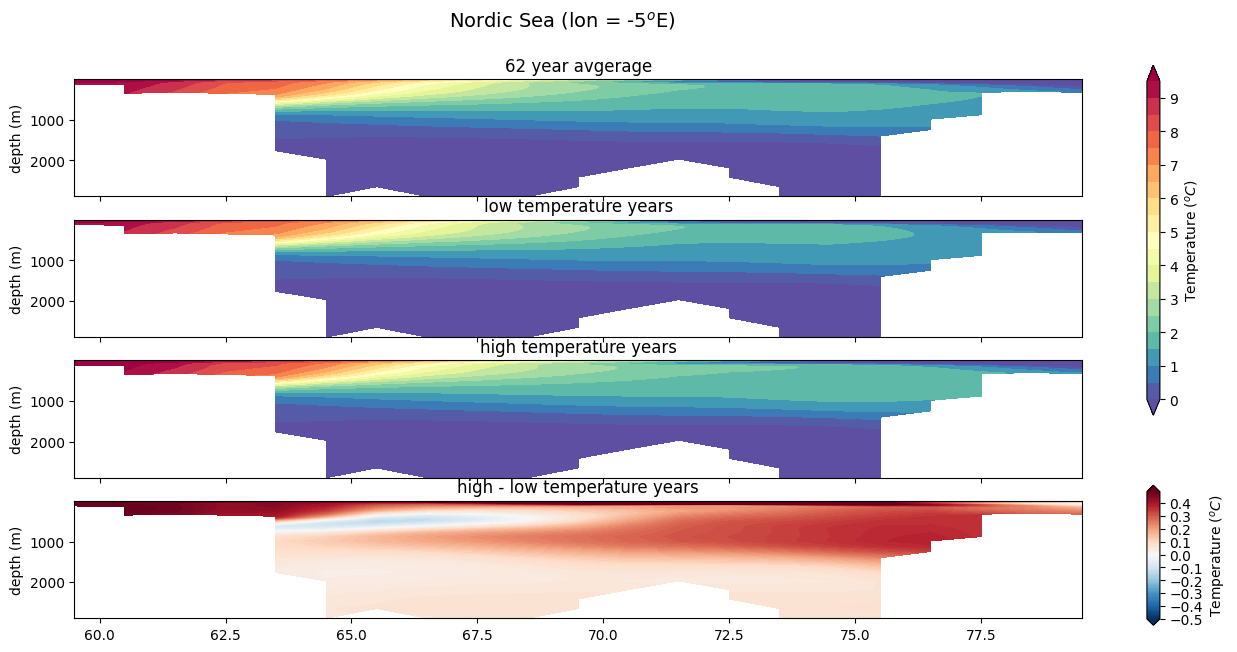

In [11]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Nordic Sea (lon = -5$^o$E)', fontsize=14)

ax = fig.add_subplot(4,1,1)
levels = np.arange(0,10,0.5)
pc=ax.contourf(x2, y2, temp2, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('62 year avgerage')
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(4,1,2)
pc=ax.contourf(x2, y2, temp_low, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('low temperature years')
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(4,1,3)
pc=ax.contourf(x2, y2, temp_high, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high temperature years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.5])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Temperature ($^oC$)',extend='both')

ax = fig.add_subplot(4,1,4)
levels = np.arange(-0.5,0.5,0.01)
pc=ax.contourf(x2, y2, temp_high-temp_low, levels=levels,cmap='RdBu_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high - low temperature years')
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.2])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Temperature ($^oC$)',extend='both')

## Let's do the same thing for nutrients 

In [12]:
### First 20 year climatology GNG595
file = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid'
newNCDFfiles1 = sorted(glob(f'{file}/regrid_SPECTRA_NO3.*.nc', recursive=True),
                      key=numericalSort)
ds_02= xr.open_mfdataset(newNCDFfiles1[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [13]:
%%time
no3_ds_inter = np.empty([62,12,60,180,360])
no3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    no3_ds_inter[i,:,:,:,:] = ds_02.NO3[x[i]:x[i]+12,:,:,:]

CPU times: user 22.4 s, sys: 1min 16s, total: 1min 39s
Wall time: 7min 44s


In [14]:
x2 = ds_01.lat[149:170] # Latitude 
y2 = ds_01.z_t[0:50]/100 # convert cm to m 
no3 = np.nanmean(no3_ds_inter[:,:,0:50,149:170,175],axis=(0,1)) # Average through months and 62 years... 
no3_low = np.nanmean(no3_ds_inter[low_no3_years_arctic,:,0:50,149:170,175],axis=(0,1,2))
no3_high = np.nanmean(no3_ds_inter[high_no3_years_arctic,:,0:50,149:170,175],axis=(0,1,2))

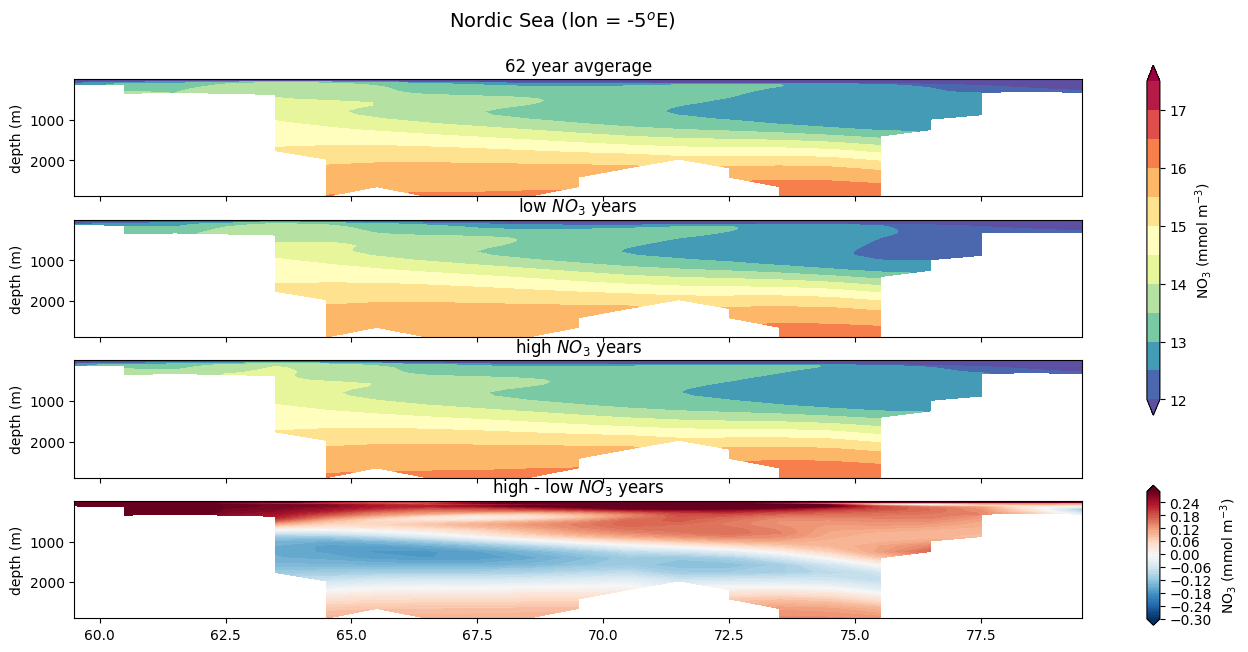

In [15]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Nordic Sea (lon = -5$^o$E)', fontsize=14)

ax = fig.add_subplot(4,1,1)
levels = np.arange(12,18,0.5)
pc=ax.contourf(x2, y2, no3, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('62 year avgerage')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,2)
pc=ax.contourf(x2, y2, no3_low, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('low $NO_3$ years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,3)
pc=ax.contourf(x2, y2, no3_high, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high $NO_3$ years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()
#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.5])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol m$^{-3}$)',extend='both')

ax = fig.add_subplot(4,1,4)
levels = np.arange(-0.3,0.3,0.01)
pc=ax.contourf(x2, y2, no3_high-no3_low, levels=levels,cmap='RdBu_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high - low $NO_3$ years')
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.2])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol m$^{-3}$)',extend='both')

## Let's do the same thing for phytoplankton biomass --- regridded by seasons..

In [16]:
### First 20 year climatology GNG595
file = '/glade/u/home/gabyn/scratch/SPECTRA/nc_files/'
ds_spring= xr.open_mfdataset(f'{file}/regrid_spring_phyto_bmss_62yr_depth.nc')
ds_summer= xr.open_mfdataset(f'{file}/regrid_summer_phyto_bmss_62yr_depth.nc')
ds_fall= xr.open_mfdataset(f'{file}/regrid_fall_phyto_bmss_62yr_depth.nc')
ds_winter= xr.open_mfdataset(f'{file}/regrid_winter_phyto_bmss_62yr_depth.nc') # Full 62 years of second cycle regridded

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr_depth.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr_depth.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset lon
			found dataset lat
			found dataset z_t_150m
			found dataset photoC_TOT_spring
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x7e0000 ext_ncid 0x7e0000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/regrid_spring_phyto_bmss_62yr_depth.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 1
		 DIMENSION - dimid: 1 name: lon len: 360 unlimited: 0
		 DIMENSION - dimid: 2 name: lat len: 180 unlimited: 0
		 DIMENSION - dimid: 3 name: z_t_150m l

In [17]:
photoC_TOT_spring = np.array(ds_spring.photoC_TOT_spring)

		NC4_inq_var_all: ncid 0x7e0000 varid 4
		NC4_inq_var_all: ncid 0x7e0000 varid 4
		NC4_inq_dim: ncid 0x7e0000 dimid 0
		NC4_inq_dim: ncid 0x7e0000 dimid 3
		NC4_inq_dim: ncid 0x7e0000 dimid 2
		NC4_inq_dim: ncid 0x7e0000 dimid 1
		NC4_inq_dim: ncid 0x7e0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x7e0000 dimid 3
		NC4_inq_dim: ncid 0x7e0000 dimid 2
		NC4_inq_dim: ncid 0x7e0000 dimid 1
		NC4_inq_var_all: ncid 0x7e0000 varid 4
		NC4_inq_var_all: ncid 0x7e0000 varid 4
		NC4_inq_dim: ncid 0x7e0000 dimid 0
		NC4_inq_dim: ncid 0x7e0000 dimid 3
		NC4_inq_dim: ncid 0x7e0000 dimid 2
		NC4_inq_dim: ncid 0x7e0000 dimid 1
		NC4_inq_var_all: ncid 0x7e0000 varid 4
		NC4_inq_var_all: ncid 0x7e0000 varid 4
		NC4_inq_dim: ncid 0x7e0000 dimid 0
		NC4_inq_dim: ncid 0x7e0000 dimid 3
		NC4_inq_dim: ncid 0x7e0000 dimid 2
		NC4_inq_dim: ncid 0x7e0000 dimid 1
		NC4_inq_var_all: ncid 0x7e0000 varid 4
			NC4_get_vars: var->hdr.name photoC_TOT_spring mem_nc_type 5
		NC4_inq_dim: nc

In [18]:
x2 = ds_01.lat[149:170] # Latitude 
y2 = ds_spring.z_t_150m[0:10]/100 # convert cm to m 
phyto = np.nanmean(photoC_TOT_spring[:,0:10,149:170,175],axis=(0)) # Average through months and 62 years... 
phyto_low = np.nanmean(photoC_TOT_spring[low_temp_years_arctic,0:10,149:170,175],axis=(0,1))
phyto_high = np.nanmean(photoC_TOT_spring[high_temp_years_arctic,0:10,149:170,175],axis=(0,1))

In [19]:
np.nanmax(phyto)

3.8314614e-05

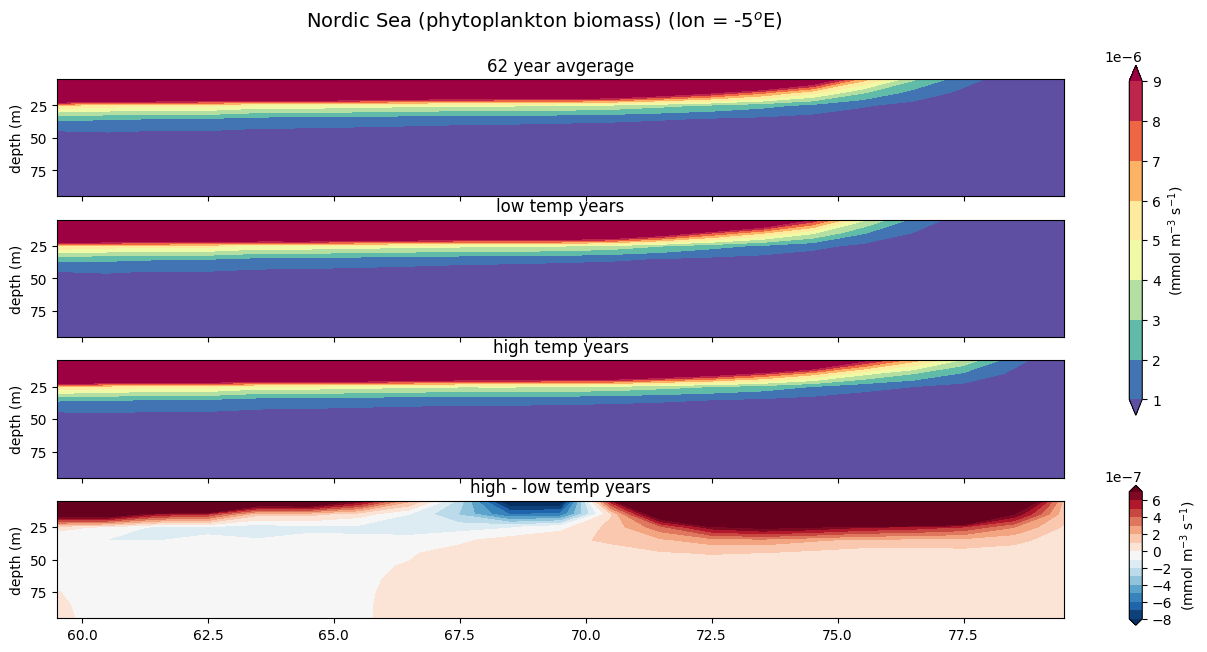

In [20]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Nordic Sea (phytoplankton biomass) (lon = -5$^o$E)', fontsize=14)

ax = fig.add_subplot(4,1,1)
levels = np.arange(0.000001,0.00001,0.000001)
pc=ax.contourf(x2, y2, phyto, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('62 year avgerage')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,2)
pc=ax.contourf(x2, y2, phyto_low, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('low temp years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,3)
pc=ax.contourf(x2, y2, phyto_high, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high temp years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.5])
cbar = fig.colorbar(pc, cax=cbar_ax, label='(mmol m$^{-3}$ s$^{-1}$)',extend='both')

ax = fig.add_subplot(4,1,4)
levels = np.arange(-0.8e-6,0.8e-6,0.0000001)
pc=ax.contourf(x2, y2, phyto_high-phyto_low,levels=levels,cmap='RdBu_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high - low temp years')
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.2])
cbar = fig.colorbar(pc, cax=cbar_ax, label='(mmol m$^{-3}$ s$^{-1}$)',extend='both')

In [21]:
%%time
ice_ds_inter = np.empty([62,12,180,360])
ice_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ice_ds_inter[i,:,:,:] = ds_03.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

NameError: name 'ds_03' is not defined

## Now let's do the same thing for the central Arctic to see how different this might be looking there?

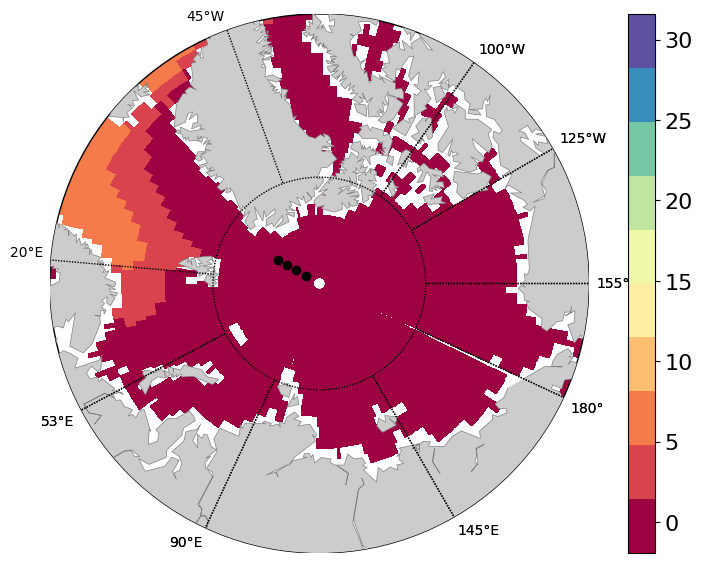

In [22]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True,
            boundinglat=65,
            lon_0=180+(-100+-30)/2.,resolution='c')

x, y = m(*np.meshgrid(ds_01.lon,ds_01.lat))

m.pcolormesh(x,y,temp_ds_inter[0,0,0,:,:],shading='flat',cmap=plt.cm.get_cmap('Spectral', 10))
cbar=plt.colorbar() 
cbar.ax.tick_params(labelsize=16)

x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[175]))
m.plot(x1,y1,'o',color='k')
x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[176]))
m.plot(x1,y1,'o',color='k')
x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[177]))
m.plot(x1,y1,'o',color='k')
x1, y1 = m(*np.meshgrid(ds_01.lon[175],ds_01.lat[178]))
m.plot(x1,y1,'o',color='k')


m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
m.plot
plt.show()

In [ ]:
x3 = ds_01.lat[170:180] # Latitude 
y3 = ds_01.z_t[0:50]/100 # convert cm to m 
temp3 = np.nanmean(temp_ds_inter[:,:,0:50,170:180,175],axis=(0,1)) # Average through months and 62 years... 
temp_low = np.nanmean(temp_ds_inter[low_temp_years_arctic,:,0:50,170:180,175],axis=(0,1,2))
temp_high = np.nanmean(temp_ds_inter[high_temp_years_arctic,:,0:50,170:180,175],axis=(0,1,2))

In [ ]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Central Arctic (lon = -5$^o$E)', fontsize=14)

ax = fig.add_subplot(4,1,1)
levels = np.arange(0,1.5,0.1)
pc=ax.contourf(x3, y3, temp3, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('62 year avgerage')
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(4,1,2)
pc=ax.contourf(x3, y3, temp_low, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('low temperature years')
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(4,1,3)
pc=ax.contourf(x3, y3, temp_high, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high temperature years')
ax.invert_yaxis()
ax.xaxis.set_ticklabels([])
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.5])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Temperature ($^oC$)',extend='both')

ax = fig.add_subplot(4,1,4)
levels = np.arange(-0.5,0.5,0.01)
pc=ax.contourf(x3, y3, temp_high-temp_low, levels=levels,cmap='RdBu_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high - low temperature years')
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.2])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Temperature ($^oC$)',extend='both')

In [ ]:
x3 = ds_01.lat[170:180] # Latitude 
y3 = ds_01.z_t[0:50]/100 # convert cm to m 
no3 = np.nanmean(no3_ds_inter[:,:,0:50,170:180,175],axis=(0,1)) # Average through months and 62 years... 
no3_low = np.nanmean(no3_ds_inter[low_no3_years_arctic,:,0:50,170:180,175],axis=(0,1,2))
no3_high = np.nanmean(no3_ds_inter[high_no3_years_arctic,:,0:50,170:180,175],axis=(0,1,2))

In [ ]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Central Arctic Sea (lon = -5$^o$E)', fontsize=14)

ax = fig.add_subplot(4,1,1)
levels = np.arange(12,15,0.1)
pc=ax.contourf(x3, y3, no3, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('62 year avgerage')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,2)
pc=ax.contourf(x3, y3, no3_low, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('low $NO_3$ years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,3)
pc=ax.contourf(x3, y3, no3_high, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high $NO_3$ years')
ax.invert_yaxis()
ax.xaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.5])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol m$^{-3}$)',extend='both')

ax = fig.add_subplot(4,1,4)
levels = np.arange(-0.3,0.3,0.01)
pc=ax.contourf(x3, y3, no3_high-no3_low,levels=levels,cmap='RdBu_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high - low temp years')
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.2])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol m$^{-3}$)',extend='both')

In [ ]:
x3 = ds_01.lat[170:180] # Latitude 
y3 = ds_spring.z_t_150m[0:10]/100 # convert cm to m 
phyto = np.nanmean(photoC_TOT_spring[:,0:10,170:180,175],axis=(0)) # Average through months and 62 years... 
phyto_low = np.nanmean(photoC_TOT_spring[low_no3_years_arctic,0:10,170:180,175],axis=(0,1))
phyto_high = np.nanmean(photoC_TOT_spring[high_no3_years_arctic,0:10,170:180,175],axis=(0,1))

In [ ]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Central Arctic total C Fixation (mmol m$^{-3}$ s$^{-1}$) (lon = -5$^o$E)', fontsize=14)

ax = fig.add_subplot(4,1,1)
levels = np.arange(0,0.0000001,0.00000001)
pc=ax.contourf(x3, y3, phyto, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('62 year avgerage')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,2)
pc=ax.contourf(x3, y3, phyto_low, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('low temp years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

ax = fig.add_subplot(4,1,3)
pc=ax.contourf(x3, y3, phyto_high, levels=levels, cmap='Spectral_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high temp years')
ax.xaxis.set_ticklabels([])
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.5])
cbar = fig.colorbar(pc, cax=cbar_ax, label='(mmol m$^{-3}$ s$^{-1}$)',extend='both')

ax = fig.add_subplot(4,1,4)
levels = np.arange(-0.5e-8,0.5e-8,0.00000001)
pc=ax.contourf(x3, y3, phyto_high-phyto_low,levels=levels,cmap='RdBu_r',extend='both')
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.set_title('high - low temp years')
ax.invert_yaxis()

#fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.2])
cbar = fig.colorbar(pc, cax=cbar_ax, label='(mmol m$^{-3}$ s$^{-1}$)',extend='both')